<h1><center>
    <img src="https://raw.githubusercontent.com/ramp-kits/stroke/master/figs/logo_inria.png" width="150px"/><img src="https://raw.githubusercontent.com/ramp-kits/stroke/master/figs/logo_cds.png" width="150px" />
</center>
</h1>

<div style="text-align: center">
<img src="https://raw.githubusercontent.com/ramp-kits/stroke/master/figs/stroke_logo.png" width="400px" />
</div>

# <center> RAMP: segmentation of the brain lesions </center>

<b>Authors</b>: Alexandre Hutton$^{1}$, Maria Teleńczuk$^{2}$, Swetha Shanker$^{2}$, Guillaume Lemaitre$^{2}$, Alexandre Gramfort$^{2}$, Sook-Lei Liew$^{1}$

$^{1}$: <a href="https://chan.usc.edu/npnl/">Neural Plasticity & Neurorehabilitation Lab</a>  
$^{2}$: <a href="http://www.datascience-paris-saclay.fr">Paris-Saclay Center for Data Science</a> (Inria), France

# Table of contents
1. [Introduction](#Introduction)
    1. [Motivation](#Motivation)
    2. [Setup](#Setup)
2. [Data Exploration](#data_exp)
    1. [Visualize Data](#visualize)
    1. [Paired Loading](#paired)
    2. [Lesion Analysis](#lesion)
3. [Creating Estimators](#prediction)
4. [Scores](#scores)
3. [Submission](#Submission)

# 1. Introduction <a class="anchor" id="Introduction"></a>

## Clinical/research motivation <a name=Motivation></a>

Stroke is the leading cause of adult disability worldwide, with up to two-thirds of affected individuals experiencing long-term disabilities. Large-scale neuroimaging studies have shown promise in identifying robust biomarkers (e.g. measures of brain structure) of long-term stroke recovery following rehabilitation. However, analyzing large rehabilitation-related datasets is problematic due to barriers in accurate stroke lesion segmentation. Manually-traced lesions are currently the gold standard for lesion segmentation on T1-weighted MRIs, but require anatomical expertise and are labor-intensive. Further, manual segmentation is subjective with raters producing different results. While algorithms have been developed to automate this process, the resulting lesion masks often lack the accuracy needed to make them reliable information. Newer algorithms that employ machine-learning and deep learning techniques are promising avenues, but they require large, diverse datasets for training and testing and developing generalizable models. In this challenge, training can be performed on our public ATLAS 2.0 dataset, and testing is done with a private dataset comprised of multi-site data from the same sites as ATLAS 2.0. <BR>

For more information refer to:
<a href="http://fcon_1000.projects.nitrc.org/indi/retro/atlas.html">Anatomical Tracings of Lesions After Stroke</a>

## References

<a href="https://www.sciencedirect.com/science/article/abs/pii/S1361841516301268">1. Maier, Oskar, et al. "ISLES 2015-A public evaluation benchmark for ischemic stroke lesion segmentation from multispectral MRI." Medical image analysis 35 (2017): 250-269.</a><br>

<a href="https://www.nature.com/articles/sdata201811">2. Liew, Sook-Lei, et al. "A large, open source dataset of stroke anatomical brain images and manual lesion segmentations." Scientific data 5 (2018): 180011.</a><br>


## Objective of the challenge

In this challenge you will be given 3D medical images (T1 MRI scans in `nii.gz` format) of stroke patients and the files with the corresponding lesions (binary masks) traced manually by experts. Your algorithm will be scored on the overlap between your prediction and the segmentation mask.

# Setup <a name=Setup></a>
### Prerequisites
The following cell will install the required package dependencies, if necessary. You can examine the file, `requirements.txt`, included in the repo to view the list of dependencies.
NOTE: Due to the structure of the challenge, libraries not included in `requirements.txt` will need to be added to be added via a pull request to the [GitHub repo](https://github.com/ramp-kits/stroke).

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

To get this notebook running and test your models locally using `ramp-test` (from ramp-workflow), we recommend that you use the Anaconda or Miniconda Python distribution.

# Data exploration <a name=data_exp></a>

## Data download and reformat

You can get a local (encrypted) copy of the data by going to the [NITRC website](http://fcon_1000.projects.nitrc.org/indi/retro/atlasR2_download.html) or running the following cell. The relevant code is commented to prevent accidentally downloading the (large) data. Make sure to uncomment it; you can uncomment multiple lines by highlighting them and pressing Ctrl + /  
Note that the data is approx. 15GB; ensure that you have enough space.

In [1]:
import wget, hash_check, config
url = 'ftp://www.nitrc.org/fcon_1000/htdocs/indi/retro/ATLAS/releases/R2.0/ATLAS_R2.0_encrypted.tar.gz'
filename = wget.download(url)
filename = 'ATLAS_R2.0_encrypted.tar.gz'
print('Checking the data. This may take a few minutes...')
if(hash_check.check_hash_correct(filename, config.encrypted_hash)):
    print('The correct data was downloaded!')
else:
    print('There is something wrong with the data. You may be unable to proceed.')

100% [..................................................................] 14405791055 / 14405791055Checking the data. This may take a few minutes...
The correct data was downloaded!


The data is encrypted; to obtain the password to decrypt the data, you'll need to agree to the terms of use [found on this form](https://docs.google.com/forms/d/e/1FAIpQLSclH8padHr9zwdQVx9YY_yeM_4OqD1OQFvYcYpAQKaqC6Vscg/viewform), and follow the instructions on the page to decrypt the data and extract the tarball.

Unfortunately, the data provided via INDI is not compatible with PyBIDS. You can run the following cell to correct the formatting; update the values as appropriate.
WARNING: This will move the data files on your disk. 

In [2]:
import indi_reformat
## Uncomment the following lines to correct the formatting.
atlas_2_path = 'ATLAS_2'  # Assumes that it is in the current directory. Set this to the location on your drive.
destination = 'data'  # Assumes that we're in the stroke/ directory.
indi_reformat.bidsify_indi_atlas(atlas_path=atlas_2_path, destination_path=destination)

## Viewing the data files

In your `data` folder you should now be able to find the `test` and `train` directories, each containing BIDS directories. Subject directories contain two files:
 - `sub-X_ses-Y_space-MNI152NLin2009aSym_T1w.nii.gz`
     - Structural T1 that has been defaced, resampled, and normalized to MNI152NLin2009
 - `sub-X_ses-Y_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.nii.gz`
     - Lesion mask. '1' indicates the presence of a lesion, '0' otherwise.

If you wish to view any of those files from outside of Python, you can use applications like [ITK-snap](http://www.itksnap.org/pmwiki/pmwiki.php). There, you can load the structural file as the main image and the lesion mask as a segmentation to overlap the two.

To load the images to Python, we will be using [PyBIDS](https://github.com/bids-standard/pybids). If you want to use a libarary which is not listed in `requirements.txt` or `extra_libraries.txt`, please make a pull request to the the [Stroke Lesion Segmentation Challenge repository on GitHub](https://github.com/ramp-kits/stroke) by adding the required library to [extra_libraries.txt](https://github.com/ramp-kits/stroke/blob/master/extra_libraries.txt) file).

## Visualize data <a name=visualize></a>

The data provided with this challenge are 3D images. In this section, we'll show you how to view slices of the data.
Since the data is in [BIDS](https://bids-specification.readthedocs.io/en/stable/), we can access the data fairly easily using [PyBIDS](https://github.com/bids-standard/pybids).

In [4]:
import bids
from bids import BIDSLayout
bids.config.set_option('extension_initial_dot', True)  # Warning suppression
data = BIDSLayout('data/train', derivatives=True).derivatives['ATLAS']

print(data)

BIDS Layout: ...e/data/train/derivatives/ATLAS | Subjects: 436 | Sessions: 436 | Runs: 0


We see that there are 436 subjects in the training set with a total of 436 sessions.

In [9]:
# Pick random sample
import random
subjects = data.entities['subject'].unique()
sample = random.choice(subjects)

structural = data.get(subject=sample, suffix='T1w')[0]
mask = data.get(subject=sample, suffix='mask')[0]
print(structural.filename)
print(mask.filename)

sub-r010s011_ses-1_space-MNI152NLin2009aSym_T1w.nii.gz
sub-r010s011_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.nii.gz


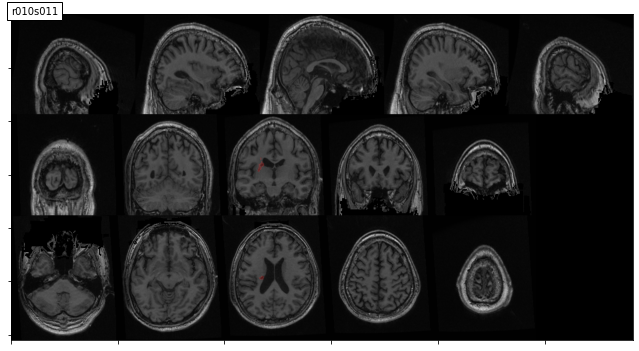

In [10]:
%matplotlib inline
from nii_slice import qc_slice
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [14, 6]
qc_slice(structural.path, mask_path=mask.path, nslices=5)

# Beautify plot
plt.text(0,0, f'{sample}', bbox={'facecolor': 'white'});  # Label which subject
plt.tick_params(axis='both', labelbottom=False, labelleft=False)

In the above image, we see slices for each plane. The masked stroke is denoted in red, although the slices may not intersect the lesion mask for every subject (re-run the last two cells to display a new subject). Some preprocessing has already been done on the images; you can review the preprocessing steps [here](https://www.nature.com/articles/sdata201811).

Due to the unreliable performance of non-linear registration with subjects with pathologies, the data was registered linearly. If you examine multiple subjects, you may notice that although the image dimensions are the same and the brains are roughly in the right area, there are differences between subjects (e.g., dimensions of the head, location of specific structures). This is typical of neuroimaging datasets.

Before we look closer at the lesions, let's look at some of the image properties:

In [11]:
print(f'Shape of structural scan: {structural.get_image().shape}')
print(structural.get_image().header)

Shape of structural scan: (197, 233, 189)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 197 233 189   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FreeSurfer Jan 18 2017'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -98.0
qoffset_y       : -134.0
qoffset

The previous cell displays some of the metadata about the file. You can [read here](https://brainder.org/2012/09/23/the-nifti-file-format/) for more information, but the shape of the data is most relevant.
Every image contains 197x233x189 (8.6M) voxels. Consequently, it is not usually possible to load the entire dataset into memory at once. We will see the effects of this in later sections.

## Paired Loading <a name=paired></a>

Loading individual files is fine for examining the data, but we need to ensure that our data and masks are paired, even if new sessions or modalities are added later. We've included a loader for this in `bids_loader.py`, as `BIDSLoader`. We can look at its docstrings to see the expected input:

In [12]:
from bids_loader import BIDSLoader
help(BIDSLoader)

Help on class BIDSLoader in module bids_loader:

class BIDSLoader(builtins.object)
 |  BIDSLoader(root_dir: str, data_entities: list, target_entities: list, batch_size: int = 1, data_derivatives_names: list = None, target_derivatives_names: list = None, root_list: list = None, label_names: list = None)
 |  
 |  BIDS-compatible data loader used for classifying BIDS datasets.
 |  Parameters
 |  ----------
 |  root_dir : str
 |      BIDS root directory; subject directories should be immediately below this (e.g. root_dir/sub-123)
 |  data_entities : list [dict]
 |      List of dictionaries, where each dictionary contains BIDS entities that will uniquely match data. Multiple
 |      dictionaries should be used to if multiple files will be used for prediction.
 |      Empty entries ({'subject': ''}) indicate that that entry should match across samples (e.g., [{'session': ''}] would
 |      ensure that entities from a returned sample are from the same session, but that any value is valid.
 | 

In [14]:
from bids_loader import BIDSLoader
training_set = BIDSLoader(root_dir='data/train/',
                          data_entities={'subject': '',
                                         'session': '',
                                         'suffix': 'T1w'},
                          target_entities={'label': 'L',
                                          'desc': 'T1lesion',
                                          'suffix': 'mask'},
                          data_derivatives_names=['ATLAS'],
                          target_derivatives_names=['ATLAS'],
                          label_names=['not lesion', 'lesion'])

The object, `training_set` now has the data list paired with the target list:

In [15]:
print(f'Image: {training_set.data_list[0]}')
print(f'Mask: {training_set.target_list[0]}')

Image: (<BIDSImageFile filename='/home/lex/NPNL/projects/strokeseg/stroke/data/train/derivatives/ATLAS/sub-r001s002/ses-1/anat/sub-r001s002_ses-1_space-MNI152NLin2009aSym_T1w.nii.gz'>,)
Mask: (<BIDSImageFile filename='/home/lex/NPNL/projects/strokeseg/stroke/data/train/derivatives/ATLAS/sub-r001s002/ses-1/anat/sub-r001s002_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.nii.gz'>,)


We can load the data/target into separate arrays:

In [16]:
data, target = training_set.load_sample(0)
print(f'data shape: {data.shape}')
print(f'target shape: {target.shape}')

data shape: (1, 197, 233, 189)
target shape: (1, 197, 233, 189)


We can also load multiple images as a batch:

In [17]:
data, target = training_set.load_batch([0,1,2])
print(f'data shape: {data.shape}')
print(f'target shape: {target.shape}')

data shape: (3, 1, 197, 233, 189)
target shape: (3, 1, 197, 233, 189)


Along with `load_image_tuple` and `load_image_tuple_list`, these methods are used during RAMP's training to feed your estimator.

## Lesion analysis <a name=lesion></a>

Now, that we understand better the anatomical T1 images that we will work with, let's look at the lesion masks. We will visualize overlap of the two:

In [18]:
from nilearn.image import load_img
from nilearn import plotting

/home/lex/NPNL/projects/strokeseg/stroke/stroke_venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


/home/lex/NPNL/projects/strokeseg/stroke/stroke_venv/lib/python3.8/site-packages/numpy/ma/core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


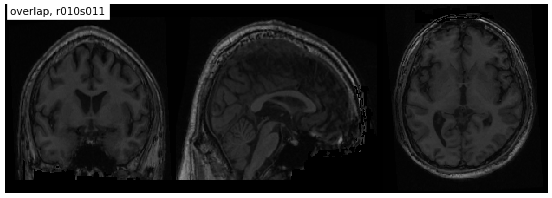

In [19]:
def plot_overlap(path_to_t1, path_to_lesion, title='overlap'):
    fig = plt.figure(1, figsize=(14, 5), frameon=False, dpi=50)
    ax = plt.gca()
    plotting.plot_roi(path_to_lesion, path_to_t1, title=title,
                       axes=ax,
                       draw_cross=False,
                       annotate=False, 
                       cmap='autumn',  # the lesions will be shown in red
                       cut_coords=(0, 0, 0)
                       )
plot_overlap(path_to_t1=structural.path,
             path_to_lesion=mask.path,
             title=f'overlap, {sample}')

Note that lesions are heterogeneous: they appear in different places, have different sizes, and are different shapes.

We can examine a number of subjects and get the overall lesions for each subject. Note that some subjects have multiple lesions, so the following value is the _lesion load_ rather than the lesion size. Even using the aggregate measure, we'll see a wide distribution.

In [20]:
from config import bids_loader_train, bids_loader_test  # Default loaders for starting kit

subset_size = 50  # number of subjects to examine; reduce if it takes too long to load
lesion_load_train = np.zeros((subset_size,))  # lesion load per subject
lesion_load_test = np.zeros((subset_size,))

# Load the data, compute the lesion load, store
for i in range(subset_size):
    target_tuple = bids_loader_train.target_list[i]
    target = bids_loader_train.load_image_tuple(target_tuple)
    lesion_load_train[i] = np.sum(target)
for i in range(subset_size):
    target_tuple = bids_loader_test.target_list[i]
    target = bids_loader_test.load_image_tuple(target_tuple)
    lesion_load_test[i] = np.sum(target)

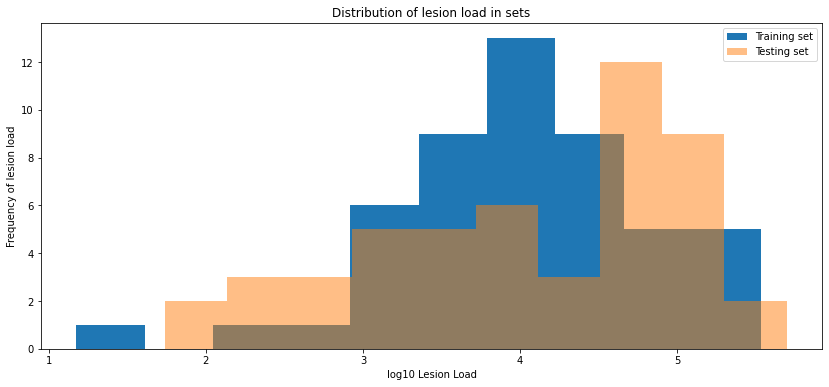

In [21]:
# Plot the distribution!
from matplotlib import pyplot as plt
plt.hist(np.log10(lesion_load_train), bins=10)  # Note the log scale
plt.hist(np.log10(lesion_load_test), bins=10, alpha=0.5)
plt.xlabel('log10 Lesion Load')
plt.ylabel('Frequency of lesion load')
plt.title('Distribution of lesion load in sets')
plt.legend(['Training set', 'Testing set'])

We can see in the distribution that even among the 100 subjects, the lesion load varies quite a bit across patients. The test set is a random subset from the same sites as the training set, but we can (qualitatively) observe different distribution between the two sets.

# Sample prediction algorithms <a name=prediction></a>

This section will show you the expected format for your estimators. We'll first go through a sample estimator that defines the required properties and methods.

## Dummy solution (predict only 1s)

The starter kit has a sample estimator in `submissions/sample/`. There, you'll find a file, `estimator.py`, which RAMP expects to have BIDSEstimator defined. The class is intentionally barebones, and is a good starting place for your own estimators.
Let's take a look at the sample class and its methods.

In [22]:
from submissions.sample.estimator import BIDSEstimator  # Load estimator
methods = [d for d in dir(BIDSEstimator) if not d.startswith('_')]  # Get methods; remove private ones.
print(methods)

['fit', 'fit_partial', 'get_params', 'predict', 'predict_proba', 'set_params']


Two of these methods, `get_params` and `set_params` are from `sklearn`'s `BIDSEstimator`. You don't need to implement these.
  
The fitting methods, `fit` and `fit_partial` are related to fitting your estimator to the data.  
`fit` expects to be given the entirety of the data to fit. You won't be able to fit all the data in memory, and as such `fit` is not required.  
`fit_partial` behaves similarly, but instead assumes that not all data is being presented at once. It is used in iterative fitting (e.g. stochastic gradient descent). This method is required.  

In [23]:
help(BIDSEstimator.fit_partial)

Help on function fit_partial in module submissions.sample.estimator:

fit_partial(self, X, y)
    Fit the estimator using the input data (X) and target (y). Assumes that the inputs represent only a fraction
    of the data and that it will be called multiple times while using the dataset. I.e., learning rates and adaptive
    parameters should not be entirely recalculated with each call to this method. Required.
    This estimator in particular does nothing.
    Parameters
    ----------
    X : np.array
        Data of the form (n_samples, n_channels, *image.shape)
    y : np.array
        Target (labels) of the form (n_samples, n_channels, *image.shape)
    
    Returns
    -------
    None



Lastly, the prediction methods, `predict` and `predict_proba` use input data and return a prediction.  
Broadly, `predict` is expected to return the predicted class (i.e. argmax instead of softmax). In the case of our binary masks, we would expect predictions of either '0' or '1'.
`predict_proba` is expected to return continuous values (i.e. softmax instead of argmax), which can be useful for model evaluation and calibration.

Scoring functions will call the relevant prediction method for their requirements, but will cast the predictions into the right type (e.g. binary) before scoring. You can implement only `predict` and then have `predict_proba` simply return the results of `predict` without issue. Having your own implementation allows you to customize parameters such as thresholds, but is not required.

In [24]:
help(BIDSEstimator.predict_proba)

Help on function predict_proba in module submissions.sample.estimator:

predict_proba(self, X)
    Applies the data to the estimator to produce a prediction. The output can be continuous to represent the
    relative confidence the estimator has in the prediction. Optional.
    Typically, correct but uncertain predictions are rewarded less. Similarly, incorrect but uncertain predictions
    are punished less severely.
    This estimator always returns 1.
    Parameters
    ----------
    X : np.array
        Data of the form (n_samples, n_channels, *image.shape)
    
    Returns
    -------
    np.array
        Prediction made by the estimator.



## Submitting to RAMP

Before submitting to RAMP, you can test your solution locally to ensure that trivial errors (e.g. typos, path issues, etc.) are resolved. We can test a given submission using the `ramp` command that was installed in the virtual environment.  
We'll use the following command:  
`!ramp test --submission sample --quick-test`  
The `!` signals that the command should be run on the command line instead of this notebook.  
`ramp` is the command to be executed.  
`test` is the first argument; it signals `ramp` to perform a local test.  
`--submission sample` specifies which submission to run. You can have multiple potential submissions in the `submissions/` directory; this prevents `ramp` from running all of them.  

In [25]:
!ramp test --submission sample

Testing ATLAS Stroke Lesion Segmentation
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/sample ...
CV fold 0
	score  Sørensen–Dice Coefficient       time
	train                      0.011  78.856910
	valid                      0.010   0.000166
	test                       0.011   0.000057
CV fold 1
	score  Sørensen–Dice Coefficient       time
	train                      0.010  80.524447
	valid                      0.012   0.000182
	test                       0.011   0.000077
CV fold 2
	score  Sørensen–Dice Coefficient       time
	train                      0.012  79.509379
	valid                      0.010   0.000176
	test                       0.011   0.000076
CV fold 3
	score  Sørensen–Dice Coefficient       time
	train                      0.011  78.810262
	valid                      0.011   0.000183
	test                       0.011   0.000078
CV fold 4
	score  Sørensen–Dice Coefficient       time
	train                      0.011  78.007823
	valid

We can see that the results are not very good, but that is expected: our estimator completely ignores the data!

RAMP will automatically perform 5-fold cross-validation and report the Sørensen–Dice for each of the folds and report the mean across the folds. Bagging of the results has been disabled; the output can be ignored.

## Scores used <a name=scores></a>
- [__Sørensen–Dice__ coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient): measures the overlap between the prediction and the ground truth. The measure is bounded between 0 and 1, with 0 indicating no overlap and 1 indicating perfect overlap.

Other scores will be added as the challenge is released, and will likely include precision and recall.
You can find the scoring metrics in the `scoring.py` file. If you want to use the score to evaluate your own results, use the `calc_score` method.

In [ ]:
from scoring import DiceCoeff
help(DiceCoeff)

In [ ]:
help(DiceCoeff.calc_score)

For the reference, if you wish to view previous medical image segmentation challenges:
    
- [Cada (Cerebral Aneurysm Detection) grand-challenge](https://cada.grand-challenge.org/)
- [Augmented Segmentation of Coronary Arteries](https://asoca.grand-challenge.org/)
- [TN (Thyroid Nodule Segmentation and Classification) SCUI2020](https://tn-scui2020.grand-challenge.org/)
- [Pneumothorax Segmentation SIIM-ACR](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation)
- [Brats brain tumor segmentation Challenge 2020](https://www.med.upenn.edu/cbica/brats2020/data.html)

## Submission

When your estimator in `estimator.py` is ready, place it in the `submissions/` directory in its own, unique directory (e.g., the path should be `submissions/my_estimator/estimator.py`).

You can then test your submission locally using the command:

`ramp test --submission <your submission folder name>`  
Example:
`ramp test --submission my_estimator`

For more information on how to submit your code on [ramp.studio](https://ramp.studio/), refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).